## how many new lncRNAs have a qtl?

In [1]:
import pandas as pd
import seaborn as sns
import pyranges as pr
import numpy as np
import matplotlib.pyplot as plt
import upsetplot as up
from matplotlib.colors import hex2color
from scipy.stats.kde import gaussian_kde
from matplotlib.colors import LogNorm
from scipy import stats
import os
from scipy.stats import sem


from tqdm.notebook import tqdm

tqdm.pandas()

/local/scratch/klawren/slrmtmp.47907055/ipykernel_5624/1650888010.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [ ]:
qval_cutoff = 0.05

In [3]:
gene_type_order = ['lncRNA', 'protein_coding', 'pseudogene', 'other_noncoding_RNA']

gene_type_pal = {'lncRNA':'#b70657',
                 'protein_coding':'#215B30',
                 'other_noncoding_RNA':'#6A5ACD',
                 'pseudogene':'#005BBF'}


gene_type_order_highlight = ['CLS_lncRNA', 'other_lncRNA', 'protein_coding', 'pseudogene', 'other_noncoding_RNA']

gene_type_pal_highlight = {'CLS_lncRNA':'#fb83ba',
                            'other_lncRNA':'#b70657',
                            'protein_coding':'#215B30',
                            'other_noncoding_RNA':'#6A5ACD',
                            'pseudogene':'#005BBF'}

In [146]:
# pull in the gene ids
gencode_ids = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching_simplified.txt', sep='\t')
gencode_ids = gencode_ids[~(gencode_ids['gene_type_grouped'] == 'artifact')]
len(gencode_ids)

79931

In [147]:
# load in the v11 qtls
v11_eqtl = pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/eqtls/Brain_Caudate_basal_ganglia.v11.eGenes.txt.gz', sep='\t')
v11_sqtl= pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/sqtls/Brain_Caudate_basal_ganglia.v11.sGenes.txt.gz', sep='\t')

# are they signifignat?
v11_eqtl['signifigant'] = v11_eqtl['qval'] < qval_cutoff
v11_sqtl['signifigant']  = v11_sqtl['qval'] < qval_cutoff

In [148]:
v10_eqtl = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_Analysis_v10_eQTL_updated/Brain_Caudate_basal_ganglia.v10.eGenes.txt.gz', sep='\t')
v10_sqtl = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_Analysis_v10_sQTL_updated/Brain_Caudate_basal_ganglia.v10.sGenes.txt.gz', sep='\t')

# are they signifignat?
v10_eqtl['signifigant'] = v10_eqtl['qval'] < qval_cutoff
v10_sqtl['signifigant']  = v10_sqtl['qval'] < qval_cutoff


In [149]:
# combine into one df
def comine_qtls(gencode_ids, eqtls, sqtls, gene_id_column):
    eqtls['is_tested'] = True
    eqtls = pd.merge(gencode_ids, eqtls[['signifigant', 'gene_id', 'variant_id', 'qval', 'is_tested']], right_on='gene_id', left_on=gene_id_column, how='left').drop(columns=['gene_id']).reset_index()
    sqtls['is_tested'] = True
    qtls = pd.merge(eqtls, sqtls[['signifigant', 'gene_id', 'variant_id', 'qval', 'is_tested']], right_on='gene_id', left_on=gene_id_column, suffixes=['_e', '_s'],  how='left').drop(columns=['gene_id']).reset_index()
    qtls[['signifigant_s', 'signifigant_e', 'is_tested_e', 'is_tested_s']] = qtls[['signifigant_s', 'signifigant_e', 'is_tested_e', 'is_tested_s']].fillna(False)
    return qtls

v11_qtls = comine_qtls(gencode_ids, v11_eqtl, v11_sqtl, gene_id_column='gene_id_v47')
v10_qtls = comine_qtls(gencode_ids, v10_eqtl, v10_sqtl,  gene_id_column='gene_id_v39')

# combine the v10 and v11
qtls = pd.merge(v11_qtls, v10_qtls[['signifigant_s', 'signifigant_e', 'gene_id_stable', 'variant_id_e', 'variant_id_s', 'qval_e', 'qval_s', 'is_tested_e', 'is_tested_s']], on='gene_id_stable', suffixes=['_v11', '_v10'], how='outer')
qtls['is_hit'] = qtls['signifigant_s_v10'] + qtls['signifigant_e_v10'] +qtls['signifigant_s_v11'] + qtls['signifigant_e_v11']
gene_type_order = ['lncRNA', 'protein_coding', 'pseudogene', 'other_noncoding_RNA']
qtls['gene_type_grouped'] = pd.Categorical(qtls['gene_type_grouped'], categories=gene_type_order, ordered=True)

# reset CLS labels
qtls['is_tested_e'] = qtls['is_tested_e_v11'] | qtls['is_tested_e_v10']
qtls['is_tested_s'] = qtls['is_tested_s_v11'] | qtls['is_tested_s_v10']
qtls['is_tested'] = qtls['is_tested_e'] | qtls['is_tested_s']
qtls['is_hit'] = qtls['signifigant_s_v10'] + qtls['signifigant_e_v10'] +qtls['signifigant_s_v11'] + qtls['signifigant_e_v11']

### Replication
this is not pi1, just a sanity check 

In [150]:
# calculate pi1
print('eQTLs replication all:')
print(qtls[qtls['signifigant_e_v10']].groupby('gene_type_grouped')['signifigant_e_v11'].mean())
print('overall: {}'.format(qtls[qtls['signifigant_e_v10']]['signifigant_e_v11'].mean()))
print('\n \nsQTLs replication all:')
print(qtls[qtls['signifigant_s_v10']].groupby('gene_type_grouped')['signifigant_s_v11'].mean())
print('overall: {}'.format(qtls[qtls['signifigant_s_v10']]['signifigant_s_v11'].mean()))

eQTLs replication all:
gene_type_grouped
lncRNA                 0.822943
protein_coding         0.920834
pseudogene             0.385646
other_noncoding_RNA    0.863636
Name: signifigant_e_v11, dtype: float64
overall: 0.8520412176512232

 
sQTLs replication all:
gene_type_grouped
lncRNA                 0.885942
protein_coding         0.977577
pseudogene             0.165746
other_noncoding_RNA         NaN
Name: signifigant_s_v11, dtype: float64
overall: 0.9190322580645162


In [151]:
# calculate pi1 for a subset
qtls_in_both = qtls[~(qtls['gene_id_v47'].isna() | qtls['gene_id_v47'].isna())]
print('eQTLs replication in both:')
print(qtls_in_both[qtls_in_both['signifigant_e_v10']].groupby('gene_type_grouped')['signifigant_e_v11'].mean())
print('overall: {}'.format(qtls_in_both[qtls_in_both['signifigant_e_v10']]['signifigant_e_v11'].mean()))
print('\n \nsQTLs replication in both:')
print(qtls_in_both[qtls_in_both['signifigant_s_v10']].groupby('gene_type_grouped')['signifigant_s_v11'].mean())
print('overall: {}'.format(qtls_in_both[qtls_in_both['signifigant_s_v10']]['signifigant_s_v11'].mean()))


eQTLs replication in both:
gene_type_grouped
lncRNA                 0.883830
protein_coding         0.921380
pseudogene             0.387128
other_noncoding_RNA    0.863636
Name: signifigant_e_v11, dtype: float64
overall: 0.8677401265721381

 
sQTLs replication in both:
gene_type_grouped
lncRNA                 0.959770
protein_coding         0.977577
pseudogene             0.165746
other_noncoding_RNA         NaN
Name: signifigant_s_v11, dtype: float64
overall: 0.927710843373494


In [152]:
# which ones fail to replicate?
replication_failures = qtls[(qtls['signifigant_e_v10'] & ~(qtls['signifigant_e_v11']))]
print(len(replication_failures[~(replication_failures['gene_id_v47'].isin(v11_eqtl['gene_id']))]))
replication_failures.groupby('gene_type_grouped').agg({'gene_id_stable':'nunique'})

950


,gene_id_stable
gene_type_grouped,
lncRNA,568
protein_coding,668
pseudogene,642
other_noncoding_RNA,3


In [153]:
replication_failures['gene_type_grouped'].value_counts()

gene_type_grouped
protein_coding         668
pseudogene             642
lncRNA                 568
other_noncoding_RNA      3
Name: count, dtype: int64

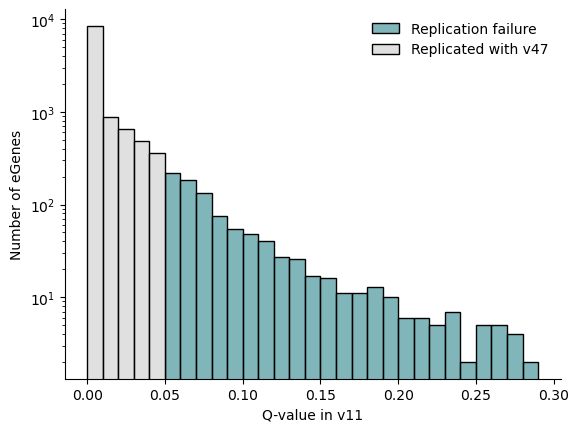

In [209]:
v11_eqtl['replicaiton_failure'] = v11_eqtl['gene_id'].isin(replication_failures['gene_id_v47'])
ax = sns.histplot(v11_eqtl[(v11_eqtl['gene_id'].isin(qtls[qtls['signifigant_e_v10']]['gene_id_v47'])) & (v11_eqtl['gene_id'].isin(qtls_in_both['gene_id_v47']))], x='qval', bins=np.arange(0, .3, .01), hue='replicaiton_failure', palette=['lightgrey', '#4a989c'], alpha=.7)
ax.set_xlabel('Q-value in v11')
ax.set_ylabel('Number of eGenes')
ax.set_yscale('log')


ax.legend(['Replication failure', 'Replicated with v47'])
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title('')
ax.spines[['top', 'right']].set_visible(False)


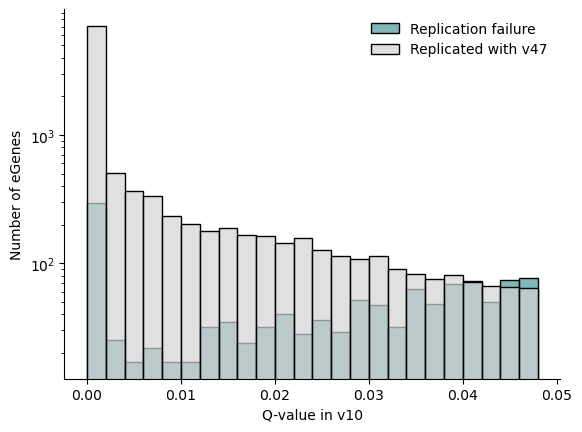

In [215]:
v10_eqtl['replicaiton_failure'] = v10_eqtl['gene_id'].isin(replication_failures['gene_id_v39'])
ax = sns.histplot(v10_eqtl[(v10_eqtl['signifigant']) & (v10_eqtl['gene_id'].isin(qtls_in_both['gene_id_v39']))], x='qval', bins=np.arange(0, .05, .002), hue='replicaiton_failure', palette=['lightgrey', '#4a989c'], alpha=.7)
ax.set_xlabel('Q-value in v10')
ax.set_ylabel('Number of eGenes')
ax.set_yscale('log')


ax.legend(['Replication failure', 'Replicated with v47'])
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title('')
ax.spines[['top', 'right']].set_visible(False)


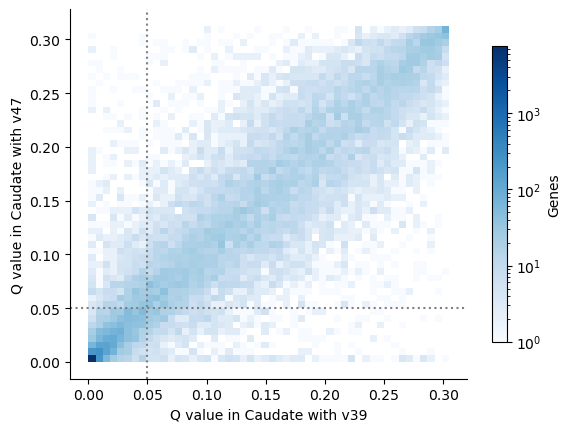

In [156]:

ax = sns.histplot(qtls_in_both, x='qval_e_v10', y='qval_e_v11', bins=50, norm=LogNorm(), log_scale=False,
                  vmin=None, vmax=None, cbar=True, cmap=sns.color_palette("Blues", as_cmap=True), cbar_kws={'shrink':.8, 'label':'Genes'})
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Q value in Caudate with v39')
ax.set_ylabel('Q value in Caudate with v47')
ax.axhline(qval_cutoff, color='grey', ls=':')
ax.axvline(qval_cutoff, color='grey', ls=':')

In [157]:
v10_quantificaiton_path = "/home/klawren/oak/gtex/data/other_references/v10/gene_tpm_v10_brain_caudate_basal_ganglia.gct.gz"
tpm_v10 = pd.read_csv(v10_quantificaiton_path, sep='\t', skiprows=2)
v10_eqtl = pd.merge(tpm_v10.set_index('Name')[tpm_v10.columns[2:]].median(axis=1.).reset_index(), v10_eqtl, left_on='Name', right_on='gene_id', how='right')

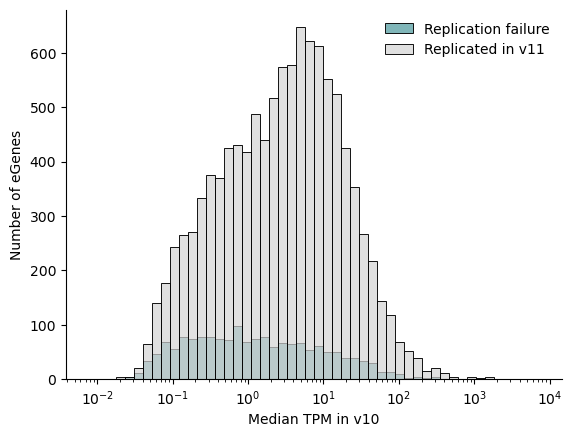

In [158]:
ax = sns.histplot(v10_eqtl[(v10_eqtl['signifigant']) & (v10_eqtl['gene_id'].isin(qtls_in_both['gene_id_v39']))], log_scale=True, x=0, bins=50, hue='replicaiton_failure', palette=['lightgrey', '#4a989c'], alpha=.7)

ax.set_xlabel('Median TPM in v10')
ax.set_ylabel('Number of eGenes')

ax.legend(['Replication failure', 'Replicated in v11'])
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title('')
ax.spines[['top', 'right']].set_visible(False)


### how many genes have a qtl?

/local/scratch/klawren/slrmtmp.47907055/ipykernel_5624/1327587730.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tissue_labels, fontsize=10)


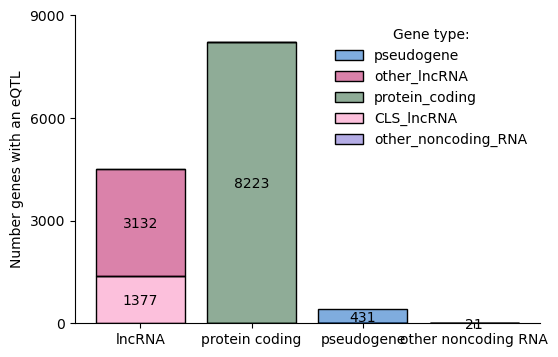

In [159]:
# how many new genes have a QTLs?

fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(qtls[qtls['signifigant_e_v11']], x='gene_type_grouped', hue='gene_type_grouped_highlight', palette=gene_type_pal_highlight,
             multiple='stack', alpha=0.5, shrink=.8, ax=ax)
            # palette=[ '#b70657', '#fb7cb6', 'grey'])

# add numbers to plot
for container in ax.containers:
    labels = [f'{int(height)}' if height > 20  else '' for height in container.datavalues]
    ax.bar_label(container, labels=labels, padding=-1, fontsize=10, label_type='center')


# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_xticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_xticklabels(tissue_labels, fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Number genes with an eQTL')
ax.set_yticks([0, 3000, 6000, 9000])

# legend

#ax.legend(['Existing', 'Partial match to v47', 'New in v47'])
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gene type:")

ax.spines[['top', 'right']].set_visible(False)
    

### upset plot of how many genes are eGenes or sGenes

In [160]:
# rename for upset plot
upset_sig_bool = qtls[((qtls['in_v47_collapsed']| qtls['in_v39_collapsed'])) & (qtls['is_hit'])].set_index('signifigant_s_v10').set_index('signifigant_e_v10', append=True).set_index('signifigant_s_v11', append=True).set_index('signifigant_e_v11', append=True)
upset_sig_bool.index.set_names(['v10 sGene', 'v10 eGene', 'v11 sGene', 'v11 eGene'], inplace=True)

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


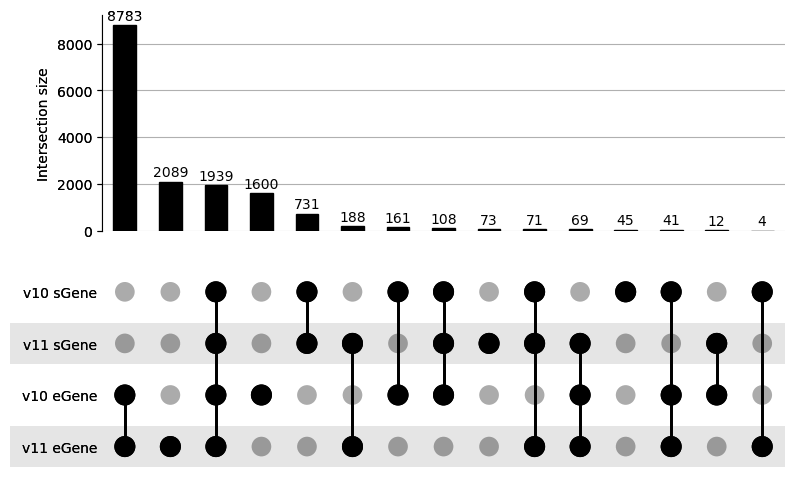

In [161]:
fig = plt.figure(figsize=(10, 6))

upset = up.UpSet(upset_sig_bool, intersection_plot_elements=4, totals_plot_elements=0, show_counts=True, 
                 element_size=None, sort_by='cardinality', min_subset_size=1)  # disable the default bar chart
#upset.add_stacked_bars(by="match_level", title="", elements=4)
plot_result = upset.plot(fig=fig)


# style the instersection plot
plot_result = upset.plot(fig=fig)
print(plot_result.keys())

# # style the stacked bar plot
# stackedbar_plot = plot_result["extra0"]
# stackedbar_plot.grid(False)
# stackedbar_plot.set_ylabel('Genes with QTL')
# stackedbar_plot.spines['bottom'].set_visible(True)

# Customize the bars to have an alpha transparency and black outlines

# for bar in stackedbar_plot.patches:
#     bar.set_edgecolor('black')  # Add black edge outline
#     bar.set_linewidth(2)  # Set the width of the edge outline
#     bar.set_alpha(0.6)  # Set transparency
    
# # add a legend
# #plt.legend(labels=['Location only in v47', 'Location only in v39', 'Location in both,\ndifferent ID', 'ID in both'], bbox_to_anchor=(1.05, 1), loc='upper left', title='ID match level')
# leg = plt.gca().get_legend()
# leg.set_frame_on(False)

plt.show()

#### upset plot only for eGenes

of those tested in caudate, how many are egenes in v11 vs v10?

Text(0.5, 0, 'Genes\n(expressed in Caudate)')

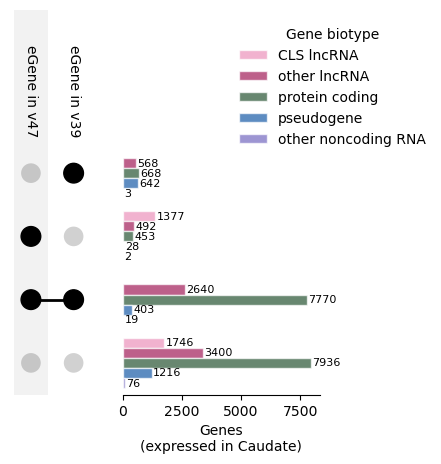

In [162]:
# rename for upset plot
upset_sig_e = qtls[qtls['is_tested_e']].set_index('signifigant_e_v10').set_index('signifigant_e_v11', append=True)
upset_sig_e.index.set_names(['eGene in v39', 'eGene in v47'], inplace=True)

qtls['sig_label'] = np.where((qtls['signifigant_e_v10']) & (qtls['signifigant_e_v11']), 2, 
                             np.where(qtls['signifigant_e_v11'], 1, 
                                      np.where(qtls['signifigant_e_v10'], 0, 3)))

fig = plt.figure(figsize=(4, 5))
upset = up.UpSet(upset_sig_e, intersection_plot_elements=4, totals_plot_elements=0, show_counts=True, 
                 element_size=None, sort_by='cardinality', min_subset_size=0, orientation='vertical')  

plot_result = upset.plot(fig=fig)
bar_ax = plot_result['intersections']
bar_ax.clear()
sns.countplot(qtls[(qtls['is_tested_e'])], y='sig_label', hue='gene_type_grouped_highlight', ax=bar_ax, palette=gene_type_pal_highlight, hue_order=gene_type_order_highlight, alpha=.7, edgecolor='white')

# add numbers to plot
for container in bar_ax.containers:
    bar_ax.bar_label(container, padding=1, fontsize=8,)

sns.move_legend(bar_ax, "upper right", bbox_to_anchor=(1.6, 1.5), frameon=False, title='Gene biotype')
legend = bar_ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)
bar_ax.set_xlabel('Genes\n(expressed in Caudate)')


In [163]:
qtls[qtls['signifigant_e_v10'] & ~qtls['signifigant_e_v11']]['gene_id_stable'].nunique()

1881

Text(0.5, 0, 'Genes\n(expressed in Caudate)')

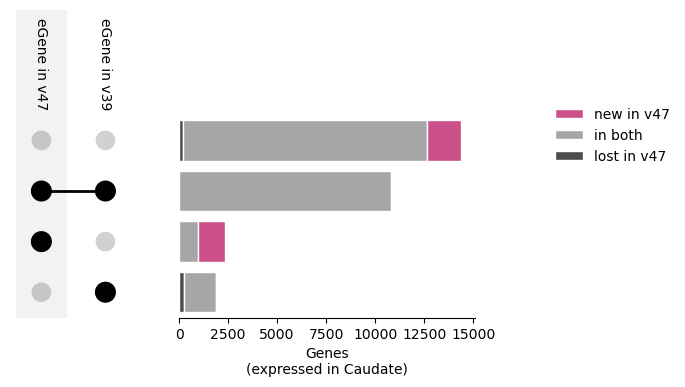

In [164]:
# rename for upset plot
upset_sig_e = qtls[qtls['is_tested_e']].set_index('signifigant_e_v10').set_index('signifigant_e_v11', append=True)
upset_sig_e.index.set_names(['eGene in v39', 'eGene in v47'], inplace=True)

qtls['sig_label'] = np.where((qtls['signifigant_e_v10']) & (qtls['signifigant_e_v11']), 2, 
                             np.where(qtls['signifigant_e_v11'], 1, 
                                      np.where(qtls['signifigant_e_v10'], 0, 3)))

fig = plt.figure(figsize=(6, 4))
upset = up.UpSet(upset_sig_e, intersection_plot_elements=4, totals_plot_elements=0, show_counts=True, 
                 element_size=None, sort_by='cardinality', min_subset_size=0, orientation='vertical')  

plot_result = upset.plot(fig=fig)
bar_ax = plot_result['intersections']
bar_ax.clear()
qtls['simplified_match_level'] = np.where(qtls['gene_id_v39'].isna(), 'new in v47', np.where(qtls['gene_id_v47'].isna(), 'lost in v47', 'in both'))
sns.histplot(qtls[(qtls['is_tested_e']) & ~(qtls['gene_type_grouped'] == 'artifact')], y='sig_label', hue='simplified_match_level', hue_order=['new in v47','in both', 'lost in v47', ],
              ax=bar_ax, alpha=.7, edgecolor='white', shrink=.8,  discrete=True, multiple='stack', palette=['#b70657', 'grey', 'black'])

# # add numbers to plot
# for container in bar_ax.containers:
#     bar_ax.bar_label(container, padding=1, fontsize=8,)

sns.move_legend(bar_ax, "upper right", bbox_to_anchor=(1.7, 1.1), frameon=False, title='')
legend = bar_ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)
bar_ax.set_xlabel('Genes\n(expressed in Caudate)')


dict_keys(['matrix', 'shading', 'totals', 'intersections'])


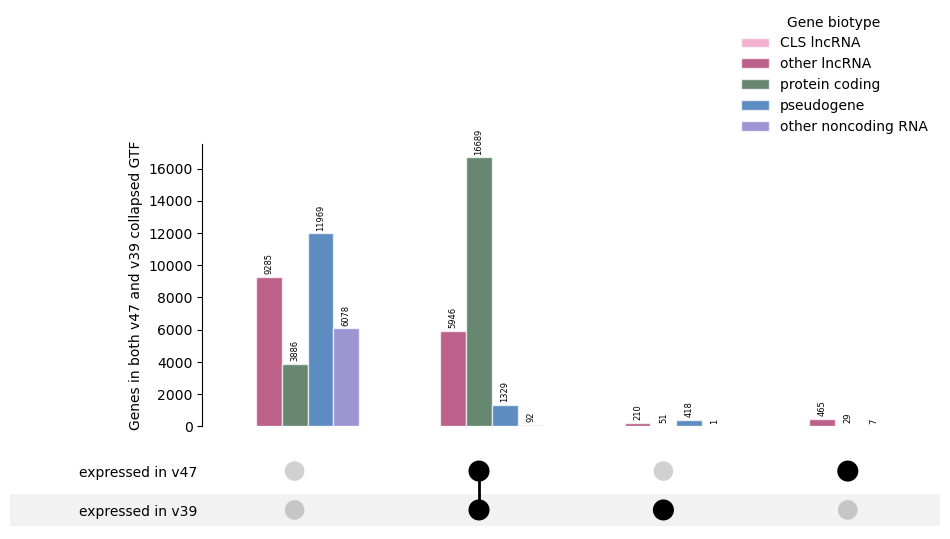

In [165]:
# threshold upset
expression_threshold_upset = up.from_indicators(qtls[qtls['in_v47_collapsed'] & qtls['in_v39_collapsed']][['is_tested_e_v10', 'is_tested_e_v11']], data=qtls[qtls['in_v47_collapsed'] & qtls['in_v39_collapsed']]['gene_type_grouped_highlight'])

expression_threshold_upset.index.set_names(['expressed in v39', 'expressed in v47'], inplace=True)
expression_threshold_upset = pd.DataFrame(expression_threshold_upset)
collapse_upset_categories = expression_threshold_upset.index.value_counts().index
category_to_idx = {category: idx for idx, category in enumerate(collapse_upset_categories)}
expression_threshold_upset['idx_loc'] = expression_threshold_upset.index.map(category_to_idx)

fig = plt.figure(figsize=(12, 5))
upset = up.UpSet(expression_threshold_upset, show_counts=False, subset_size='count', intersection_plot_elements=6, totals_plot_elements=0, element_size=None, sort_by='cardinality')
plot_result = upset.plot(fig=fig, )

print(plot_result.keys())



bar_ax = plot_result['intersections']
bar_ax.clear()
sns.countplot(expression_threshold_upset, x='idx_loc', hue='gene_type_grouped_highlight',ax=bar_ax, palette=gene_type_pal_highlight, hue_order=gene_type_order_highlight, alpha=.7, edgecolor='white', width=.7)
bar_ax.set_ylabel('Genes in both v47 and v39 collapsed GTF')
#bar_ax.set_yscale('log')

# add numbers to plot
for container in bar_ax.containers:
    bar_ax.bar_label(container, padding=2, fontsize=6, rotation=90)

sns.move_legend(bar_ax, "upper right", bbox_to_anchor=(1, 1.5), frameon=False, title='Gene biotype')
legend = bar_ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)

### lost genes

In [166]:
v39_only = qtls[~(qtls['signifigant_e_v11']) & (qtls['signifigant_e_v10'])]
v39_only['is_tested_e_v10'].value_counts()

is_tested_e_v10
True    1881
Name: count, dtype: int64

In [203]:
v39_only['lost_reason'] = 'not sure'
v39_only.loc[~(v39_only['in_v47_full']), 'lost_reason'] = 'not in v47'
v39_only.loc[((v39_only['in_v47_full']) & ~(v39_only['in_v47_collapsed'])), 'lost_reason'] = 'not quantified due to collapse in v47'
v39_only.loc[((v39_only['in_v47_collapsed']) & ~(v39_only['is_tested_e_v11'])), 'lost_reason'] = 'does not pass expression threshold with v47'
v39_only.loc[((v39_only['in_v47_collapsed']) & (v39_only['is_tested_e_v11']) & (v39_only['full_location_change_between_versions'])), 'lost_reason'] = 'location change in full GTF'
v39_only.loc[((v39_only['in_v47_collapsed']) & (v39_only['is_tested_e_v11']) & ~(v39_only['full_location_change_between_versions']) & (v39_only['collapsed_location_change_between_versions'])), 'lost_reason'] = 'location change in collapsed GTF'


#v39_only.loc[((v39_only['in_v47_collapsed']) & (v39_only['collapsed_location_change_v47'])), 'lost_reason'] = 'Gene location changes in v47 due to collapse'



/local/scratch/klawren/slrmtmp.47907055/ipykernel_5624/3900289305.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v39_only['lost_reason'] = 'not sure'


lost_reason
not sure                                       623
does not pass expression threshold with v47    381
not quantified due to collapse in v47          339
location change in full GTF                    254
not in v47                                     230
location change in collapsed GTF                54
Name: count, dtype: int64

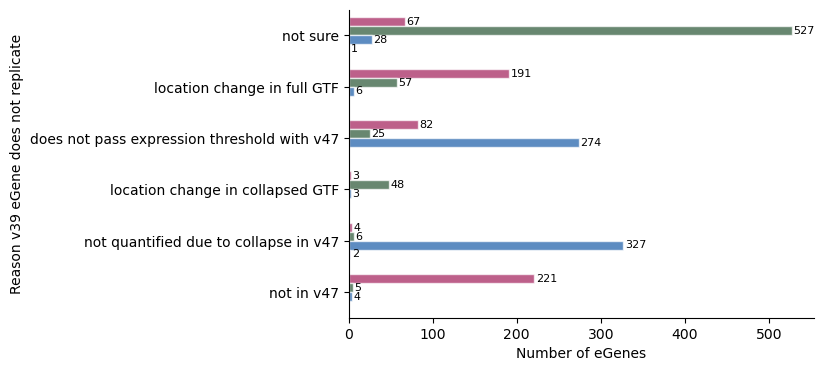

In [204]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(v39_only, y='lost_reason', hue='gene_type_grouped', hue_order=gene_type_order, palette=gene_type_pal, alpha=.7, edgecolor='white', width=.7, ax=ax, legend=False)
ax.set_ylabel('Reason v39 eGene does not replicate')
ax.set_xlabel('Number of eGenes')

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=1, fontsize=8,)

ax.spines[['top', 'right']].set_visible(False)
# sns.move_legend(ax, "upper right", bbox_to_anchor=(2, 1), frameon=False, title='Gene biotype')
# legend = ax.get_legend()
# new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
# for t, new_label in zip(legend.texts, new_labels):
#     t.set_text(new_label)
v39_only['lost_reason'].value_counts()

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


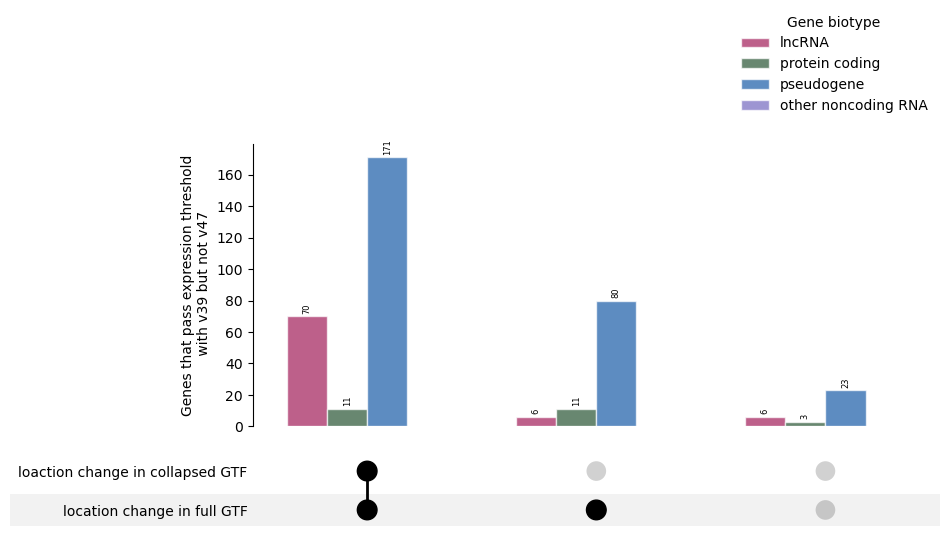

In [192]:
collapse_upset = up.from_indicators(v39_only[((v39_only['in_v47_collapsed']) & ~(v39_only['is_tested_e_v11']))][['collapsed_location_change_between_versions', 'full_location_change_between_versions']], data=v39_only[((v39_only['in_v47_collapsed']) & ~(v39_only['is_tested_e_v11']))][['gene_type_grouped']])
collapse_upset.index.set_names(['location change in full GTF', 'loaction change in collapsed GTF'], inplace=True)
collapse_upset = pd.DataFrame(collapse_upset)
collapse_upset_categories = collapse_upset.index.value_counts().index
category_to_idx = {category: idx for idx, category in enumerate(collapse_upset_categories)}
collapse_upset['idx_loc'] = collapse_upset.index.map(category_to_idx)

fig = plt.figure(figsize=(12, 5))
upset = up.UpSet(collapse_upset, show_counts=False, subset_size='count', intersection_plot_elements=6, totals_plot_elements=0, element_size=None, sort_by='cardinality')
plot_result = upset.plot(fig=fig, )

print(plot_result.keys())


bar_ax = plot_result['intersections']
bar_ax.clear()
sns.countplot(collapse_upset, x='idx_loc', hue='gene_type_grouped',ax=bar_ax, palette=gene_type_pal, hue_order=gene_type_order, alpha=.7, edgecolor='white', width=.7)
bar_ax.set_ylabel('Genes that pass expression threshold\n with v39 but not v47')
#bar_ax.set_yscale('log')

# add numbers to plot
for container in bar_ax.containers:
    bar_ax.bar_label(container, padding=2, fontsize=6, rotation=90)

sns.move_legend(bar_ax, "upper right", bbox_to_anchor=(1, 1.5), frameon=False, title='Gene biotype')
legend = bar_ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)

### nominal p values for new eGenes

In [ ]:
# p values for other v10 genes for the new gene qlts
new_eqtls = qtls[(qtls['signifigant_e_v11']) & ~(qtls['signifigant_e_v10'])]

In [ ]:
min_pval_nominal=[]
v10_dir_path = 'data/other_references/v10/qtls/GTEx_Analysis_v10_eQTL_all_associations'

def get_min_pval_df(v10_dir_path, chr_id):
    v10_nominal_chr = pd.read_parquet(f'{v10_dir_path}/Brain_Caudate_basal_ganglia.v10.allpairs.chr{chr_id}.parquet')
    v10_nominal_chr = v10_nominal_chr[v10_nominal_chr['variant_id'].isin(new_eqtls['variant_id_e_v11'])]
    min_pval_idx = v10_nominal_chr.groupby('variant_id')['pval_nominal'].idxmin()
    return v10_nominal_chr.loc[min_pval_idx][['pval_nominal', 'gene_id', 'variant_id']]

for chr_id in tqdm(range(1, 23)):
    min_pval_nominal.append(get_min_pval_df(v10_dir_path, chr_id))
min_pval_nominal.append(get_min_pval_df(v10_dir_path, 'X'))

  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
new_eqtls = pd.merge(new_eqtls, pd.concat(min_pval_nominal), how='left', left_on='variant_id_e_v11', right_on='variant_id')
print(sum(new_eqtls['pval_nominal'].isna()))
new_eqtls['pval_nominal'] = new_eqtls['pval_nominal'].fillna(1)

# add in the ene type of the gene with the min p value thats closest
new_eqtls = pd.merge(gencode_ids[['gene_id_v39', 'gene_type_grouped']].drop_duplicates('gene_id_v39'), new_eqtls, left_on='gene_id_v39', right_on='gene_id', suffixes=['_v10_min_pval', ''], how='right')

3


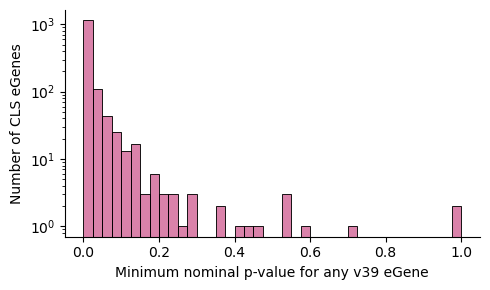

In [ ]:
# show the distirbution of minimum p values for all the new qtls
fig, ax = plt.subplots(figsize=(5, 3))

sns.histplot(new_eqtls[new_eqtls['gene_id_v39'].isna()], x='pval_nominal', ax=ax, bins=40,
             multiple='dodge', color='#b70657', alpha=.5)
ax.set_yscale('log')
ax.set_xlabel('Minimum nominal p-value for any v39 eGene')
ax.set_ylabel('Number of CLS eGenes')
ax.spines[['top', 'right']].set_visible(False)
fig.tight_layout()


### proportion plot

In [ ]:
qtls['is_cls'] = (qtls['gene_id_v39'].isna())

proportions = qtls.groupby(['gene_type_grouped', 'is_cls']).agg(
    v10_significant_count=('signifigant_e_v10', 'sum'),
    v11_significant_count=('signifigant_e_v11', 'sum'),
    v10_tested_count=('is_tested_e_v10', 'sum'),
    v11_tested_count=('is_tested_e_v11', 'sum')
).reset_index()


proportions['v10_proportion'] = proportions['v10_significant_count'] / proportions['v10_tested_count']
proportions['v11_proportion'] = proportions['v11_significant_count'] / proportions['v11_tested_count']

melt_proportions = proportions.melt(id_vars=['gene_type_grouped', 'is_cls'], value_vars=['v10_proportion', 'v11_proportion'], value_name='proportion')
melt_proportions = melt_proportions[~(melt_proportions['proportion'].isna())]

def get_ci(row):
    prop_row = proportions[(proportions['gene_type_grouped'] == row['gene_type_grouped']) & (proportions['is_cls'] == row['is_cls'])].iloc[0]
    if row['variable'] == 'v10_proportion':
        return 1.96 * np.sqrt((prop_row['v10_proportion'] * (1 - prop_row['v10_proportion'])) / prop_row['v10_tested_count'])
    else:
       return 1.96 * np.sqrt((prop_row['v11_proportion'] * (1 - prop_row['v11_proportion'])) / prop_row['v11_tested_count'])
    
melt_proportions['ci'] = melt_proportions.apply(get_ci, axis=1)
melt_proportions = melt_proportions.sort_values(['gene_type_grouped', 'variable']).reset_index(drop=True).reset_index()

/local/scratch/klawren/slrmtmp.47856788/ipykernel_7634/2666915380.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_yticklabels(labels=['v39 (all)', 'v47 (all)', 'CLS', 'v39 (all)', 'v47 (all)', 'CLS','v39 (all)', 'v47 (all)', 'v39 (all)', 'v47 (all)'])


(0.0, 1.0)

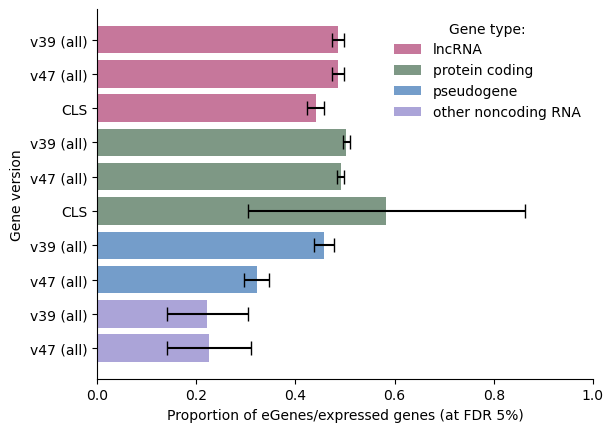

In [ ]:
bar_plot = sns.barplot(data=melt_proportions, y='index', x='proportion', hue='gene_type_grouped', palette=gene_type_pal, capsize=.1, alpha=.6, orient='horizontal')
for index, row in melt_proportions.iterrows():
    plt.errorbar(y=index, x=row['proportion'], 
                 xerr=row['ci'], 
                 fmt='none', color='black', capsize=5)
    
bar_plot.set_yticklabels(labels=['v39 (all)', 'v47 (all)', 'CLS', 'v39 (all)', 'v47 (all)', 'CLS','v39 (all)', 'v47 (all)', 'v39 (all)', 'v47 (all)'])
bar_plot.set_ylabel('Gene version')
bar_plot.set_xlabel('Proportion of eGenes/expressed genes (at FDR 5%)')
sns.move_legend(bar_plot, "upper right", bbox_to_anchor=(1, 1), frameon=False, title='Gene type:')
legend = bar_plot.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)
bar_plot.spines[['top', 'right']].set_visible(False)
bar_plot.set_xlim([0,1])

# # add numbers to plot
# for container in bar_plot.containers:
#     try:
#         bar_plot.bar_label(container, padding=-10, fontsize=8, fmt='%.2f', label_type='center')
#     except AttributeError:
#         pass



/local/scratch/klawren/slrmtmp.47856788/ipykernel_7634/3654030836.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_yticklabels(labels=melt_proportions['gene_type_words'])


(0.0, 1.0)

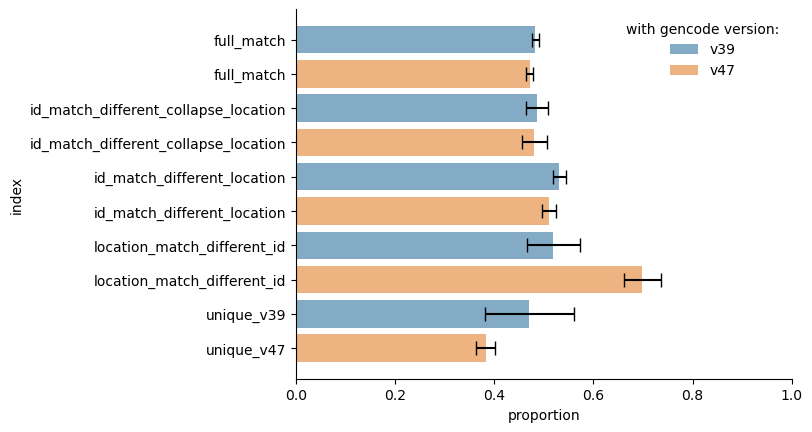

In [ ]:
qtls['gene_type_words'] = np.where(qtls['in_collapsed'] == 'v39 only', np.where(qtls['gene_id_v47'].isna(), 'Gene not in v47', 'Gene not quantified in v47 due to collapse'), 
                                    np.where(qtls['match_level']=='full_match', 'Gene quantified in both at same location', 
                                             np.where(qtls['match_level']=='id_match_different_collapse_location', 'Gene quantified at different location due to collapse trimming',
                                                      np.where(qtls['match_level']=='id_match_different_location', 'Gene quantified at different location due to ID location change', 
                                                               np.where(qtls['in_collapsed'] == 'v47 only', np.where(qtls['gene_id_v39'].isna(), 'New in v47', 'Gene not quantified in v39 due to collapse'), qtls['match_level'])))))


proportions = qtls.groupby(['gene_type_words']).agg(
    v10_significant_count=('signifigant_e_v10', 'sum'),
    v11_significant_count=('signifigant_e_v11', 'sum'),
    v10_tested_count=('is_tested_e_v10', 'sum'),
    v11_tested_count=('is_tested_e_v11', 'sum')
).reset_index()


proportions['v10_proportion'] = proportions['v10_significant_count'] / proportions['v10_tested_count']
proportions['v11_proportion'] = proportions['v11_significant_count'] / proportions['v11_tested_count']

melt_proportions = proportions.melt(id_vars=['gene_type_words'], value_vars=['v10_proportion', 'v11_proportion'], value_name='proportion')
melt_proportions = melt_proportions[~(melt_proportions['proportion'].isna())]

def get_ci(row):
    prop_row = proportions[(proportions['gene_type_words'] == row['gene_type_words'])].iloc[0]
    if row['variable'] == 'v10_proportion':
        return 1.96 * np.sqrt((prop_row['v10_proportion'] * (1 - prop_row['v10_proportion'])) / prop_row['v10_tested_count'])
    else:
       return 1.96 * np.sqrt((prop_row['v11_proportion'] * (1 - prop_row['v11_proportion'])) / prop_row['v11_tested_count'])
    
melt_proportions['ci'] = melt_proportions.apply(get_ci, axis=1)
melt_proportions = melt_proportions.sort_values(['gene_type_words', 'variable']).reset_index(drop=True).reset_index()


v11 = melt_proportions[melt_proportions['variable'] == 'v11_proportion'].reset_index(drop=True).reset_index()

bar_plot = sns.barplot(data=v11, y='level_0', x='proportion', hue='gene_type_words',  capsize=.1, alpha=.6, orient='horizontal', legend=False)
for index, row in v11.iterrows():
    plt.errorbar(y=index, x=row['proportion'], 
                 xerr=row['ci'], 
                 fmt='none', color='black', capsize=5)
    
bar_plot.set_ylabel('')
bar_plot.set_xlabel('Proportion of eGenes/expressed genes (at FDR 5%)')
bar_plot.set_yticklabels(v11['gene_type_words'])

bar_plot.spines[['top', 'right']].set_visible(False)
bar_plot.set_xlim([0,1])

### p value replicaiton for genes in both

In [ ]:
v10_dir_path = 'data/other_references/v10/qtls/GTEx_Analysis_v10_eQTL_all_associations'
v10_nominal = pd.read_parquet(f'{v10_dir_path}/Brain_Caudate_basal_ganglia.v10.allpairs.chr20.parquet')

In [ ]:
v11_dir_path = 'output/caudate_analysis/eqtls'
v11_nominal = pd.read_parquet(f'{v11_dir_path}/Brain_Caudate_basal_ganglia.v11.allpairs.chr20.parquet')

In [ ]:
v11_nominal['stable_gene_id'] = v11_nominal['gene_id'].str.split('.').str[0]
v10_nominal['stable_gene_id'] = v10_nominal['gene_id'].str.split('.').str[0]
combined_nominal = pd.merge(v11_nominal, v10_nominal, on=['stable_gene_id', 'variant_id'], how='inner', suffixes=['_v11', '_v10'])

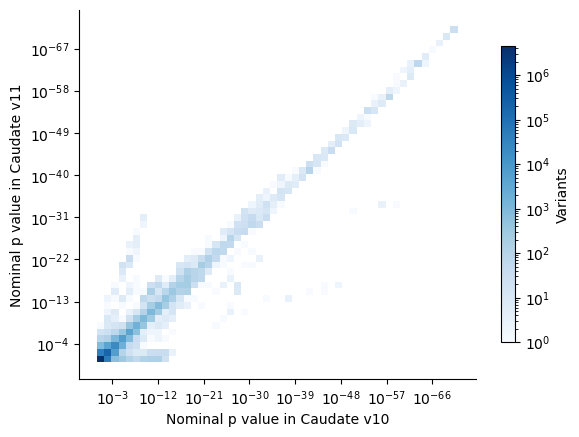

In [ ]:
ax = sns.histplot(combined_nominal, x='pval_nominal_v10', y='pval_nominal_v11', bins=50, norm=LogNorm(), log_scale=True,
                  vmin=None, vmax=None, cbar=True, cmap=sns.color_palette("Blues", as_cmap=True), cbar_kws={'shrink':.8, 'label':'Variants'})
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Nominal p value in Caudate v10')
ax.set_ylabel('Nominal p value in Caudate v11')
ax.invert_xaxis()
ax.invert_yaxis()

combined_nominal['pval_nominal_v10'].corr(combined_nominal['pval_nominal_v11'])
